<a href="https://colab.research.google.com/github/gramdishatrust/VARTA-AI/blob/main/gemma_3_1b_it_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FINE TUNING**

# **Libraries Used**
It is important to use the arguments and version numbers as is else Colab may crash. Current version of VARTA-AI works with these specific libraries only!!

**torch** - Core deep learning framework used to train and run neural network models on CPU/GPU.

**torchvision** - Provides utilities for computer vision models (not directly used).

**transformers**- Loads, fine-tunes, and runs pretrained language models for text generation and chatbots.

**trl** - Enables instruction and chat fine-tuning of language models using SFT, PPO, and DPO.

**accelerate** - Optimizes training by efficiently managing GPU, mixed precision, and distributed setups.

**datasets** - Handles loading, preprocessing, and splitting of training and evaluation datasets.

**huggingface_hub** - Manages downloading, uploading, and versioning of models and datasets.

**sentencepiece** - Performs subword tokenization required by most modern large language models.

**pyarrow** - Enables fast, memory-efficient dataset storage and processing.

**evaluate**- Computes evaluation metrics such as BERTScore, ROUGE, BLEU, and perplexity.

In [ ]:
# ============================================
# 1. INSTALL LIBRARIES
# ============================================
#!pip uninstall -y torch torchvision torchaudio transformers trl accelerate datasets huggingface_hub
#!pip install -q torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124
#!pip install -q transformers==4.45.2 trl==0.11.6 accelerate==1.1.1 datasets==3.1.0 huggingface_hub==0.28.1 sentencepiece pyarrow==18.0.0 evaluate tensorboard
!pip uninstall -y torch torchvision torchaudio transformers trl accelerate datasets huggingface_hub
!pip install -q torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q transformers==4.45.2 trl==0.11.6 accelerate==1.1.1 datasets==3.1.0 huggingface_hub==0.28.1 sentencepiece pyarrow==18.0.0
!pip install -q datasets trl sentencepiece huggingface_hub
!pip install evaluate




Setting up the environment by importing all the required libraies

The Token (hf_token) is to be acquired from [Huggingface](https://huggingface.co/settings/tokens); MOdels such as Smollm also work without a Token. In VARTA-AI as we are mainly using Google Gemma, it is necessary to generate a token for this variable. For this code to work once it is fetched from Github a fresh token and replace it in the

HF_TOKEN = "hf_token"

In [ ]:
# ============================================
# 2. SETUP AND AUTHENTICATION
# ============================================
import torch
import os
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    pipeline,
)
from trl import SFTTrainer, SFTConfig
from huggingface_hub import login
import evaluate

# Login to Hugging Face
HF_TOKEN = "hf_token"
#if using Google Colab Secret Key Valut use the code below and disable HF_TOKEN = "hf_token" above
#from google.colab import userdata
#HF_TOKEN = userdata.get('secretName')
login(token=HF_TOKEN)

# Configure Model And Load Dataset
***********
Here we are defining the base model(base_model) which we are using and the output(output_dir) where the fine-tuned model will be saved.
*************
Then we load the dataset(data_file) and split it into training (80%), validation (10%), and test (10%) sets, and finally inspect the split sizes and a sample data point to ensure that the dataset is correctly prepared for fine-tuning




In [ ]:
# ============================================
# 3. CONFIGURE MODEL AND DIRECTORIES
# ============================================
base_model = "google/gemma-3-1b-it"
#Modify base models as per need
#base_model = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
#base_model = "meta-llama/Llama-3.2-1B-Instruct"
#base_model = "Qwen/Qwen2.5-0.5B-Instruct"

#all Model files shall be located in this dir for transfer to Huggingface
output_dir = "./xLM-natural-farming-qa"


# ============================================
# 4. LOAD AND PREPARE THE DATASET
# ============================================

from datasets import load_dataset

data_file = "/content/nf_datasett.jsonl"

# Load dataset
dataset = load_dataset(
    "json",
    data_files=data_file,
    split="train"
)

# Shuffle - to randomise the data for training - seed variable is based on HH Guide to the Galaxy
dataset = dataset.shuffle(seed=42)

# 80% train, 10% val, 10% test
train_test = dataset.train_test_split(test_size=0.2)
val_test = train_test["test"].train_test_split(test_size=0.5)

#create dataset Dictionary tables for the trainer to parse
dataset_dict = {
    "train": train_test["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
}

# Visually Inspect dataset
print("✅ Dataset Split Summary:")
print(
    f"Train: {len(dataset_dict['train'])} | "
    f"Validation: {len(dataset_dict['validation'])} | "
    f"Test: {len(dataset_dict['test'])}"
)

print("\nExample data sample:")
print(dataset_dict["train"][0]["messages"])


#Load Model and Tokenization
Here we are loading the pretrained causal language model and its tokenizer. It will automatically place the model on the available GPU/GPU.




In [ ]:
# ============================================
# 5. LOAD MODEL AND TOKENIZER
# ============================================
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)
print(f"✅ Model loaded on {model.device} | dtype: {model.dtype}")

#Hyperparameter Tuning
An epoch is one complete pass of the entire training dataset through the model during fine-tuning; increasing epochs allows the model to learn more from the data but too many epochs can cause overfitting. For VARTA-AI we observed optimal training with 3 epochs. If the data volume is high then greater epochs will be resource heavy and may overfit the model
*************************************
Keep batch size=2 and gradient accumulation=4 for memory efficiency as changing these may cause CUDA out-of-memory crash.



*   Small batch size (2) → reduces GPU memory usage
*   Gradient accumulation (4) → simulates an effective batch size of 8 (2 × 4) without increasing memory load


Gradient accumulation (4) → simulates an effective batch size of 8 (2 × 4) without increasing memory load
*************************************


*   logging_steps = 10 means the training process logs metrics such as loss every 10 training steps
*************************************
learning_rate = 2e-5 sets a small step size for updating model weights during training, ensuring stable fine-tuning without drastically altering the pretrained knowledge.
*************************************

The remaining arguments to this function are stardard usage

In [ ]:
# ============================================
# 6. CONFIGURE THE TRAINING PROCESS
# ============================================
sft_config = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=3,
    # max_seq_length=256, # Removed max_seq_length
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    bf16=torch.cuda.is_bf16_supported(),
    fp16=False,
    push_to_hub=False,
    report_to="tensorboard"
)


# Training
Here the training will happen as we are initializing the supervised fine-tuning trainer(SFTTrainer).
After the training ends the model will get saved in the output directory(output_dir).

The files from the ouput_dir are to be manually uploaded to the Huggingface Model for saving the [Model](https://huggingface.co/new) for usage with the User Interface through [Spaces](https://huggingface.co/new-space)

In [ ]:
# ============================================
# 7. TRAIN AND VALIDATE MODEL
# ============================================
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    processing_class=tokenizer,
)

print("🚀 Starting fine-tuning...")
trainer.train()

print("💾 Saving final model...")
trainer.save_model(output_dir)



#Testing

In [ ]:
!pip install rouge_score

ROUGE/ BLUE Scores<br>

By computing BLEU and ROUGE, you get a quantitative measure of how closely the model’s responses match the expected answers, help assessing response quality and detect underfitting or overfitting before deployment.
***********************************************************
**NOTE:** The model achieved low BLEU and ROUGE scores but high BERTScore, indicating that it generates semantically correct responses with different phrasing than the references, which is expected in open-ended conversational tasks.

In [ ]:

# ============================================
# 8. VALIDATE MODEL PERFORMANCE
# ============================================
print("\n🔍 Validating model on validation set...")
model.eval()

# Use a simple text-generation pipeline
val_pipe = pipeline("text-generation", model=output_dir, tokenizer=tokenizer)

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

generated_texts = []
reference_texts = []

for i, sample in enumerate(dataset_dict["validation"]):
    user_msg = [{"role": "user", "content": sample["messages"][0]["content"]}]
    prompt = tokenizer.apply_chat_template(user_msg, tokenize=False, add_generation_prompt=True)
    output = val_pipe(prompt, max_new_tokens=128, num_return_sequences=1)[0]["generated_text"][len(prompt):].strip()
    generated_texts.append(output)
    reference_texts.append(sample["messages"][1]["content"])
    if i < 3:
        print(f"\nExample {i+1}:")
        print(f"Q: {sample['messages'][0]['content']}")
        print(f"Model: {output}")
        print(f"Ref: {sample['messages'][1]['content']}")

# Compute metrics
bleu_score = bleu.compute(predictions=generated_texts, references=reference_texts)
rouge_score = rouge.compute(predictions=generated_texts, references=reference_texts)

print("\n📊 Validation Metrics:")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")

BERTScore is basically used to evaluate the semantic similarity between the generated and reference text. Unlike the BLEU/ROUGE scores, which are token-based metrics, BERTScore captures contextual meaning and is better suited for domain-specific question answering where multiple valid phrasings exist.

In [ ]:

!pip install bert_score
bertscore = evaluate.load("bertscore")
results = bertscore.compute(predictions=generated_texts, references=reference_texts, lang="en")
print(sum(results["f1"]) / len(results["f1"]))

# Interaction
You can interact with the model here by asking the questions.<br>
The finetuned model is called here using output directory(output_dir).

In [ ]:
# ============================================
# 9. TEST INTERACTIVELY
# ============================================
print("\n--- Interactive Testing ---")
test_pipe = pipeline("text-generation", model=output_dir, tokenizer=tokenizer)

while True:
    question = input("\nEnter your question (or type 'exit' to quit): ").strip()
    if question.lower() == "exit":
        print("👋 Exiting...")
        break

    messages = [{"role": "user", "content": question}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = test_pipe(prompt, max_new_tokens=256)
    print(f"\n🧠 Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")


#Alternative to Google Colab---> [Kaggle](https://www.kaggle.com/)

Google colab have GPU constraint, access to GPUs is based on dynamic usage limits and availability after which you caanot use GPU and have to shift to CPU which doesnt have enough compute power.<br>
**Kaggle**<br>
Kaggle on the other hand povide 2 GPU's (GPU T4 *2 , GPU P100) which are better than google colab and give **30 hrs of monthly compute each.**
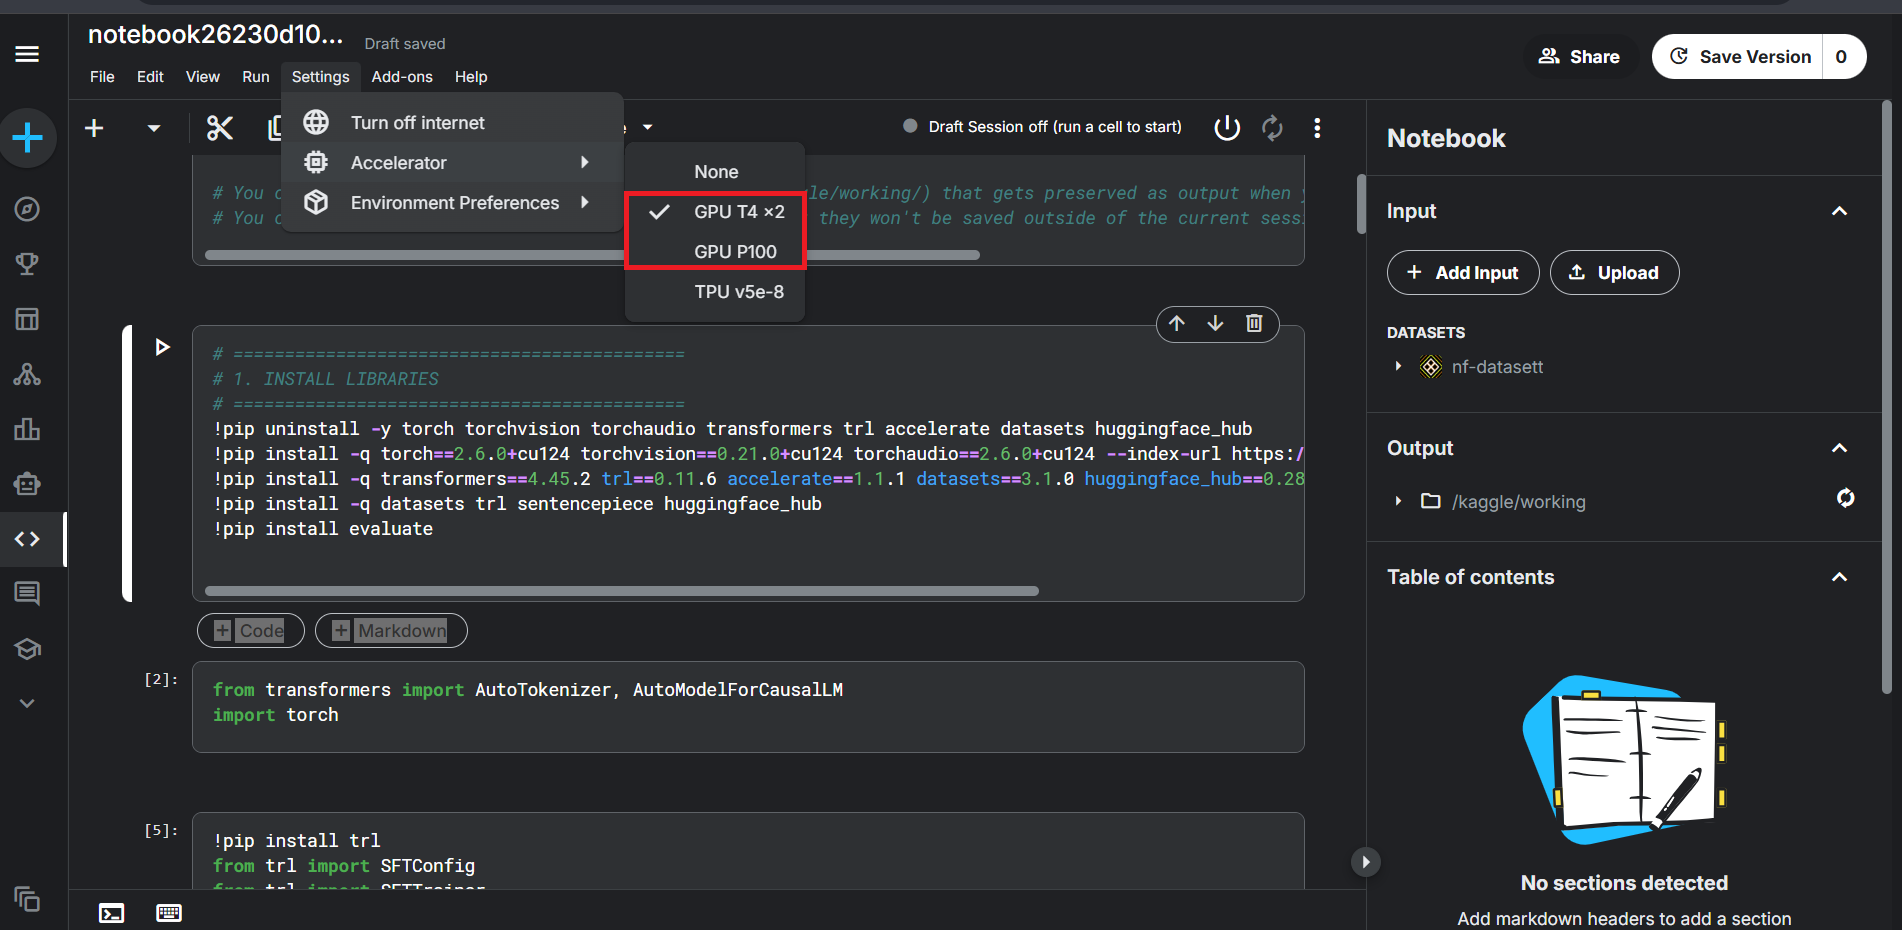

# Ensure that you **switch on the internet in kaggle** so that you can access the huggingface models.
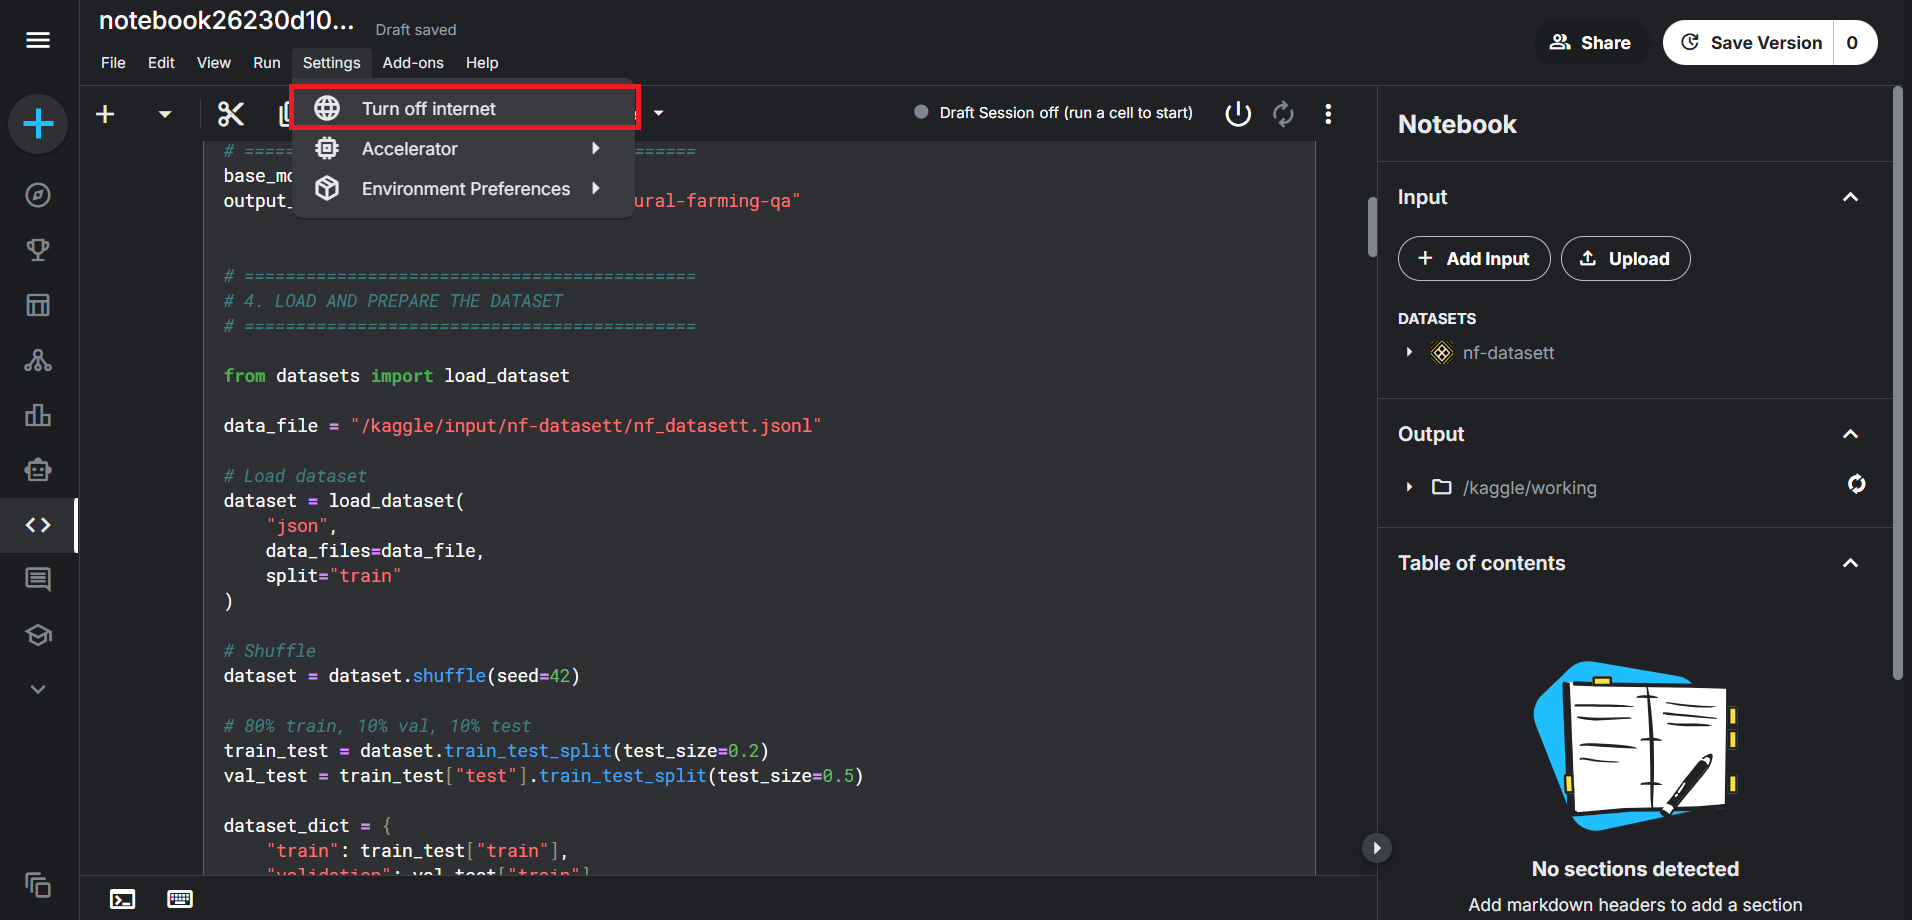

# You have to upload the dataset in **[Input -> addinput]** and the output is just below the dataset
 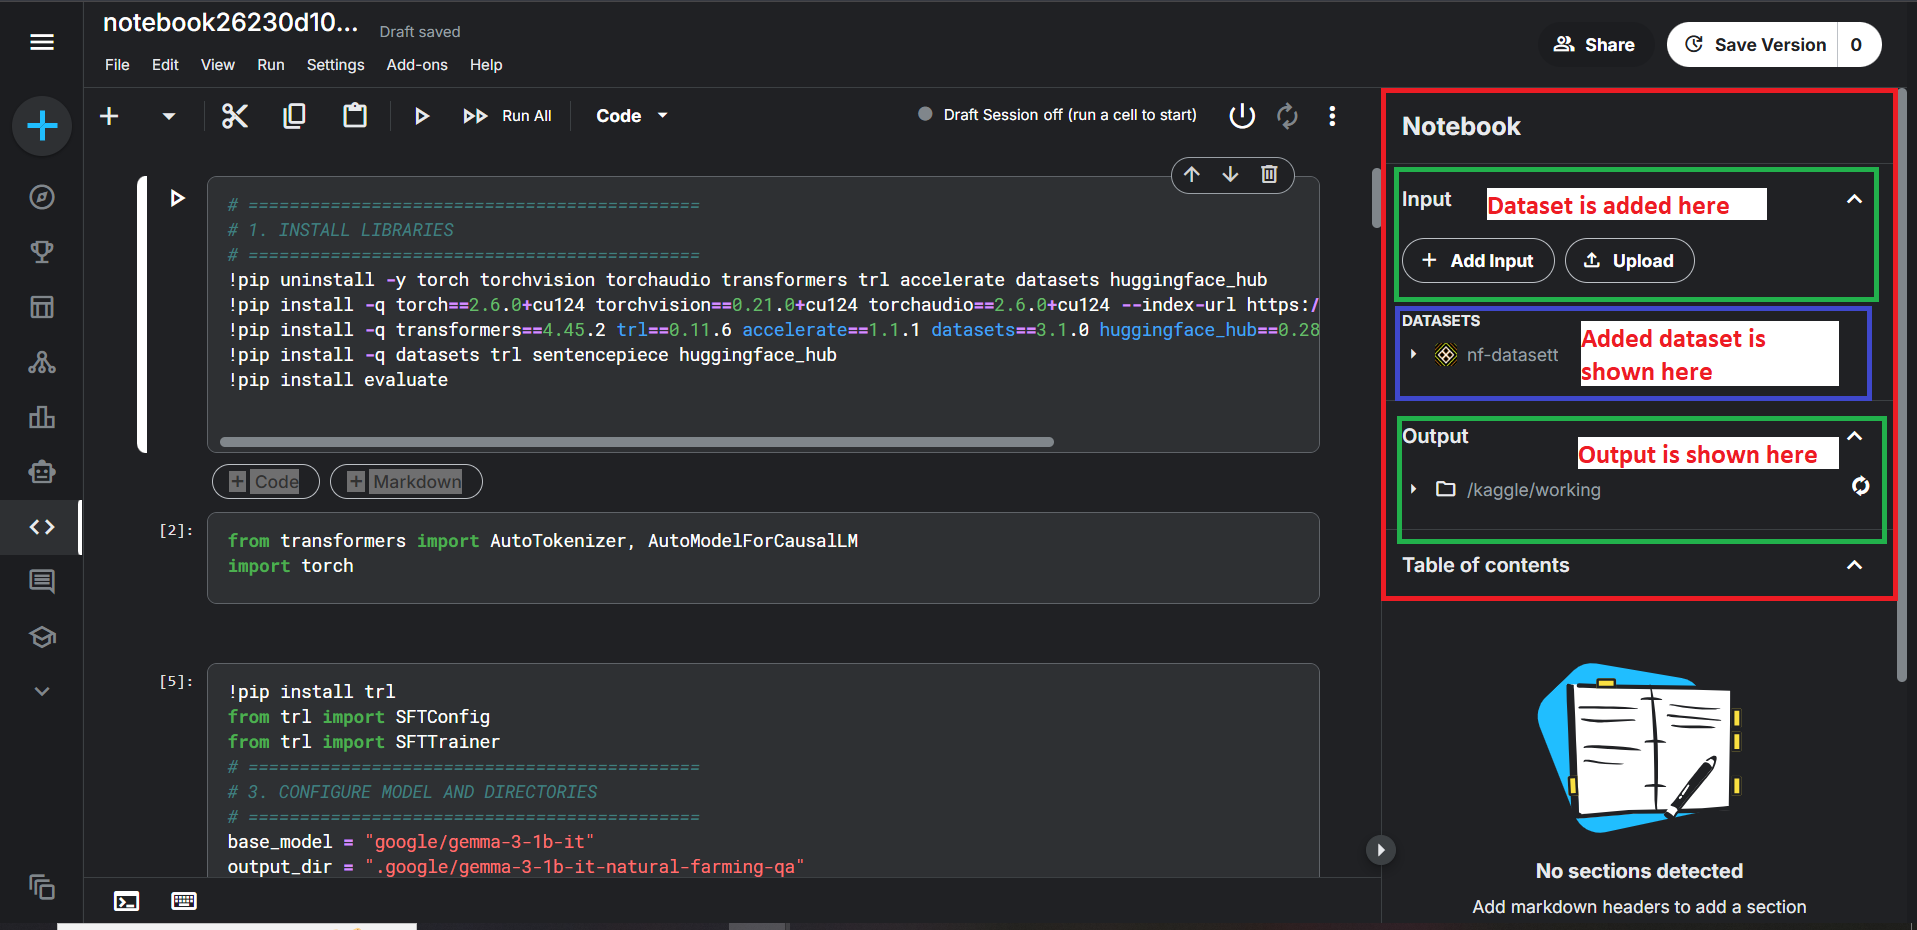